# Step 5b — 8‑Qubit Variational Quantum Classifier (VQC) with SPSA

Standalone 8‑qubit VQC:
- Inputs: **8 PCA features** → angle encoding on **8 qubits**
- Ansatz: RY/RZ locals, ring **CRY/CRZ**, **IsingXX**, **Toffoli** ring, extra RY
- Readout: **multi‑qubit** (⟨Z⟩ on all qubits) with a linear head
- Optimizer: **pure‑Python SPSA**, class‑weighted BCE, full‑batch by default
- Strategy: **one‑vs‑rest** (5 binary VQCs)

**Requires**: `../data/processed/pca8_train.csv`, `../data/processed/pca8_test.csv`

## Install (run if needed)

In [1]:
# %pip install pennylane pandas numpy scikit-learn matplotlib

## Config

In [ ]:

from pathlib import Path
import math

BASE_DATA = Path("../data")
PROCESSED_DIR = BASE_DATA / "processed"

TRAIN_CSV = PROCESSED_DIR / "pca3_train.csv"
TEST_CSV  = PROCESSED_DIR / "pca3_test.csv"

PC_COLS = ["PC1","PC2","PC3"]
N_QUBITS = len(PC_COLS)
ALL_CLASSES = ["angry", "fearful", "happy", "neutral", "sad"]

LAYERS = 2
MAX_ITERS = 200
BATCH_SIZE = None
SEED = 7

SPSA_STEPSIZE = 0.10
SPSA_PERTURB  = 0.08
LOG_EVERY = 10
RESAMPLINGS = 3
ANGLE_CLIP = math.pi

OUT_DIR = PROCESSED_DIR / "vqc8_models_spsa"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("TRAIN_CSV:", TRAIN_CSV.resolve())
print("TEST_CSV :", TEST_CSV.resolve())


TRAIN_CSV: /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca8_train.csv
TEST_CSV : /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca8_test.csv


## Debug — verify PCA(8) files exist

In [3]:

missing = []
if not TRAIN_CSV.exists(): missing.append(str(TRAIN_CSV))
if not TEST_CSV.exists():  missing.append(str(TEST_CSV))
if missing:
    raise SystemExit("Missing required file(s):\n  - " + "\n  - ".join(missing))
else:
    print("PCA(8) files found ✓")


PCA(8) files found ✓


## Imports & utilities

In [4]:

import json, random
import numpy as onp
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

pnp.random.seed(SEED); onp.random.seed(SEED); random.seed(SEED)

def load_data(train_csv, test_csv, pc_cols, valid_classes):
    tr = pd.read_csv(train_csv)
    te = pd.read_csv(test_csv)
    tr = tr[tr["emotion"].isin(valid_classes)].reset_index(drop=True)
    te = te[te["emotion"].isin(valid_classes)].reset_index(drop=True)
    for col in pc_cols + ["emotion"]:
        assert col in tr.columns and col in te.columns, f"Missing column: {col}"
    return tr, te

def build_angle_scaler(train_df, pc_cols, clip=np.pi):
    scales = {}
    for k in pc_cols:
        m = float(train_df[k].abs().max())
        scales[k] = {"denom": max(1e-8, 1.1*m), "clip": clip}
    return scales

def apply_angle_scaler(df, pc_cols, scales):
    X = df[pc_cols].to_numpy(onp.float32)
    for j, key in enumerate(pc_cols):
        d = scales[key]["denom"]; c = scales[key]["clip"]
        X[:, j] = np.clip((X[:, j] / d) * c, -c, c)
    return X

def one_vs_rest_labels(df, positive_class):
    return (df["emotion"].values == positive_class).astype(onp.float64)


## Quantum model — encoder + rich ansatz + multi‑qubit readout

In [5]:

dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)

def encode_angles(angles):
    for i, ang in enumerate(angles):
        qml.RY(ang, wires=i)

def ansatz(theta):
    L = theta["single"].shape[0]
    for l in range(L):
        for q in range(N_QUBITS):
            qml.RY(theta["single"][l, q, 0], wires=q)
            qml.RZ(theta["single"][l, q, 1], wires=q)
        for q in range(N_QUBITS):
            qn = (q + 1) % N_QUBITS
            qml.CRY(theta["ent"][l, q, 0], wires=[q, qn])
            qml.CRZ(theta["ent"][l, q, 1], wires=[q, qn])
        for q in range(N_QUBITS):
            qn = (q + 1) % N_QUBITS
            qml.IsingXX(theta["ising"][l, q], wires=[q, qn])
        if N_QUBITS >= 3:
            for q in range(N_QUBITS):
                q1, q2, tgt = q, (q+1) % N_QUBITS, (q+2) % N_QUBITS
                qml.Toffoli(wires=[q1, q2, tgt])
        for q in range(N_QUBITS):
            qml.RY(theta["mix"][l, q, 0], wires=q)

@qml.qnode(dev)
def vqc_multi(angles, theta):
    encode_angles(angles)
    ansatz(theta)
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


## Parameter packing, prediction, and loss

In [6]:

SINGLE_SZ = LAYERS * N_QUBITS * 2
ENT_SZ    = LAYERS * N_QUBITS * 2
ISING_SZ  = LAYERS * N_QUBITS * 1
MIX_SZ    = LAYERS * N_QUBITS * 1
THETA_SIZE = SINGLE_SZ + ENT_SZ + ISING_SZ + MIX_SZ
READOUT_SIZE = N_QUBITS + 1

def unpack_params(params):
    idx = 0
    single = params[idx: idx+SINGLE_SZ]; idx += SINGLE_SZ
    ent    = params[idx: idx+ENT_SZ];    idx += ENT_SZ
    ising  = params[idx: idx+ISING_SZ];  idx += ISING_SZ
    mix    = params[idx: idx+MIX_SZ];    idx += MIX_SZ
    single = single.reshape(LAYERS, N_QUBITS, 2)
    ent    = ent.reshape(LAYERS, N_QUBITS, 2)
    ising  = ising.reshape(LAYERS, N_QUBITS)
    mix    = mix.reshape(LAYERS, N_QUBITS, 1)
    W = params[idx: idx+N_QUBITS]; idx += N_QUBITS
    b = params[idx]
    theta = {"single": single, "ent": ent, "ising": ising, "mix": mix}
    return theta, W, b

def init_params(scale=0.1):
    single0 = pnp.random.uniform(-scale, scale, size=(LAYERS, N_QUBITS, 2))
    ent0    = pnp.random.uniform(-scale, scale, size=(LAYERS, N_QUBITS, 2))
    ising0  = pnp.random.uniform(-scale, scale, size=(LAYERS, N_QUBITS))
    mix0    = pnp.random.uniform(-scale, scale, size=(LAYERS, N_QUBITS, 1))
    W0      = pnp.zeros(N_QUBITS); b0 = pnp.array(0.0)
    flat = pnp.concatenate([single0.ravel(), ent0.ravel(), ising0.ravel(), mix0.ravel(), W0, pnp.array([b0])])
    return flat

def sigmoid(x): return 1/(1+pnp.exp(-x))

def predict_probs(params, X):
    theta, W, b = unpack_params(params)
    outs = []
    for i in range(X.shape[0]):
        evs = pnp.array(vqc_multi(X[i], theta))
        outs.append(sigmoid(pnp.dot(W, evs) + b))
    return pnp.array(outs, dtype=pnp.float64)

def bce_loss(params, X, y):
    p = predict_probs(params, X); eps=1e-9
    return -pnp.mean(y*pnp.log(p+eps) + (1-y)*pnp.log(1-p+eps))

def bce_loss_weighted(params, X, y, pos_weight=1.0):
    p = predict_probs(params, X); eps=1e-9
    return -pnp.mean(pos_weight*y*pnp.log(p+eps) + 1.0*(1-y)*pnp.log(1-p+eps))


## SPSA optimizer (pure‑Python)

In [7]:

def _spsa_schedule(k, a0=0.1, c0=0.1, A=None, alpha=0.602, gamma=0.101, max_iters=150):
    if A is None: A = 0.1 * max_iters
    ak = a0 / ((k + A) ** alpha)
    ck = c0 / (k ** gamma)
    return ak, ck

def train_binary_spsa(X, y, max_iters=150, batch_size=None,
                      stepsize=0.1, perturb=0.1, log_every=10,
                      resamplings=1, seed=7, loss_fn=None):
    rng = np.random.default_rng(seed)
    n_params = THETA_SIZE + READOUT_SIZE
    params = rng.uniform(-0.1, 0.1, size=n_params).astype(np.float64)
    best_loss = float("inf"); best_params = params.copy(); losses = []

    def get_batch():
        if batch_size is None or batch_size >= len(X): return X, y
        idx = rng.permutation(len(X))[:batch_size]; return X[idx], y[idx]

    if loss_fn is None: loss_fn = bce_loss

    for it in range(1, max_iters+1):
        Xb, yb = get_batch()
        a_k, c_k = _spsa_schedule(it, a0=stepsize, c0=perturb, max_iters=max_iters)
        ghat = np.zeros_like(params)
        for _ in range(resamplings):
            delta = rng.choice([-1.0, 1.0], size=n_params).astype(np.float64)
            Lp = float(loss_fn(params + c_k*delta, Xb, yb))
            Lm = float(loss_fn(params - c_k*delta, Xb, yb))
            ghat += ((Lp - Lm)/(2.0*c_k)) * delta
        ghat /= float(resamplings)
        params = params - a_k * ghat
        curr = float(loss_fn(params, Xb, yb)); losses.append(curr)
        if curr < best_loss - 1e-9: best_loss, best_params = curr, params.copy()
        if it % log_every == 0:
            print(f"iter {it:04d} | loss {curr:.4f} | best {best_loss:.4f} | a_k={a_k:.4g} c_k={c_k:.4g}")
    return best_params, np.array(losses, dtype=np.float64)


## Train one‑vs‑rest VQCs

In [8]:

train_df, test_df = load_data(TRAIN_CSV, TEST_CSV, PC_COLS, ALL_CLASSES)
angle_scales = build_angle_scaler(train_df, PC_COLS, clip=ANGLE_CLIP)
X_train = apply_angle_scaler(train_df, PC_COLS, angle_scales).astype(np.float64)
X_test  = apply_angle_scaler(test_df,  PC_COLS, angle_scales).astype(np.float64)

results = {}
for cls in ALL_CLASSES:
    print("\n=== OVR:", cls, "===")
    y_train = one_vs_rest_labels(train_df, cls).astype(np.float64)
    y_test  = one_vs_rest_labels(test_df,  cls).astype(np.float64)

    pos = y_train.sum(); neg = len(y_train) - pos
    pos_weight = float(neg / max(1.0, pos))
    loss_fn = lambda p,X,y: bce_loss_weighted(p, X, y, pos_weight=pos_weight)

    params, losses = train_binary_spsa(
        X_train, y_train, max_iters=MAX_ITERS, batch_size=BATCH_SIZE,
        stepsize=SPSA_STEPSIZE, perturb=SPSA_PERTURB, log_every=LOG_EVERY,
        resamplings=RESAMPLINGS, seed=SEED, loss_fn=loss_fn
    )

    def probs(p, X): return np.asarray(predict_probs(p, X), dtype=np.float64)
    p_tr = probs(params, X_train); p_te = probs(params, X_test)
    yhat_tr = (p_tr >= 0.5).astype(int); yhat_te = (p_te >= 0.5).astype(int)

    def safe_auc(y_true, s):
        try: return roc_auc_score(y_true, s)
        except Exception: return np.nan

    acc_tr = accuracy_score(y_train, yhat_tr)
    acc_te = accuracy_score(y_test,  yhat_te)
    auc_tr = safe_auc(y_train, p_tr); auc_te = safe_auc(y_test,  p_te)
    print(f"[{cls}] train acc={acc_tr:.3f} auc={auc_tr:.3f} | test acc={acc_te:.3f} auc={auc_te:.3f}")

    theta, W, b = unpack_params(params)
    cls_dir = OUT_DIR / cls; cls_dir.mkdir(parents=True, exist_ok=True)
    np.savez(cls_dir / "params.npz",
             theta_single=np.asarray(theta["single"]),
             theta_ent=np.asarray(theta["ent"]),
             theta_ising=np.asarray(theta["ising"]),
             theta_mix=np.asarray(theta["mix"]),
             W=np.asarray(W), b=float(b),
             layers=LAYERS, n_qubits=N_QUBITS)
    np.savetxt(cls_dir / "losses.txt", losses)

    try:
        plt.figure(); plt.plot(losses); plt.xlabel("Iter"); plt.ylabel("Loss"); plt.title(f"Loss — {cls}"); plt.tight_layout()
        plt.savefig(cls_dir / "loss.png", dpi=150); plt.close()
    except Exception: pass

    results[cls] = {"train_acc": float(acc_tr), "test_acc": float(acc_te),
                    "train_auc": None if np.isnan(auc_tr) else float(auc_tr),
                    "test_auc":  None if np.isnan(auc_te) else float(auc_te)}

with open(OUT_DIR / "angle_scales.json", "w") as f:
    json.dump(angle_scales, f, indent=2)

print("\nSaved models to:", OUT_DIR.resolve())
import pandas as pd
pd.DataFrame(results).T



=== OVR: angry ===
iter 0010 | loss 1.0829 | best 1.0829 | a_k=0.01291 c_k=0.0634


KeyboardInterrupt: 

## Multiclass evaluation

In [ ]:

def load_class_params(cls):
    d = np.load(OUT_DIR / cls / "params.npz", allow_pickle=True)
    theta = {"single": d["theta_single"], "ent": d["theta_ent"], "ising": d["theta_ising"], "mix": d["theta_mix"]}
    W = d["W"]; b = float(d["b"])
    return theta, W, b

def predict_proba_ovr(X, classes):
    scores = []
    for cls in classes:
        theta, W, b = load_class_params(cls)
        vec = []
        for i in range(X.shape[0]):
            evs = vqc_multi(X[i], theta)
            vec.append(1/(1+np.exp(-(np.dot(W, evs) + b))))
        scores.append(np.asarray(vec, dtype=np.float64))
    return np.stack(scores, axis=1)

proba_te = predict_proba_ovr(X_test, ALL_CLASSES)
pred_idx = np.argmax(proba_te, axis=1)
pred_lbl = [ALL_CLASSES[i] for i in pred_idx]
true_lbl = test_df["emotion"].tolist()

acc_multi = accuracy_score(true_lbl, pred_lbl)
print("Multiclass test accuracy:", round(acc_multi, 3))
print("\nClassification report:\n", classification_report(true_lbl, pred_lbl, labels=ALL_CLASSES))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(true_lbl, pred_lbl, labels=ALL_CLASSES))


## Circuit visualization

0: ──RY(0.21)───RY(0.00)──RZ(0.00)─╭●────────╭●───────────────────────────────────────────────
1: ──RY(0.12)───RY(0.00)──RZ(0.00)─╰RY(0.00)─╰RZ(0.00)─╭●────────╭●───────────────────────────
2: ──RY(-0.56)──RY(0.00)──RZ(0.00)─────────────────────╰RY(0.00)─╰RZ(0.00)─╭●────────╭●───────
3: ──RY(0.56)───RY(0.00)──RZ(0.00)─────────────────────────────────────────╰RY(0.00)─╰RZ(0.00)
4: ──RY(-0.24)──RY(0.00)──RZ(0.00)────────────────────────────────────────────────────────────
5: ──RY(0.03)───RY(0.00)──RZ(0.00)────────────────────────────────────────────────────────────
6: ──RY(0.24)───RY(0.00)──RZ(0.00)────────────────────────────────────────────────────────────
7: ──RY(-0.89)──RY(0.00)──RZ(0.00)────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────────────────╭RY(0.00)
──────────────────────────────────────────────────────────────────────────────────│────────
───────────────────────────────────────────────────────

/var/folders/j_/78k8swfs0h5cbxl5zkwdzb400000gn/T/ipykernel_4007/1689855731.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


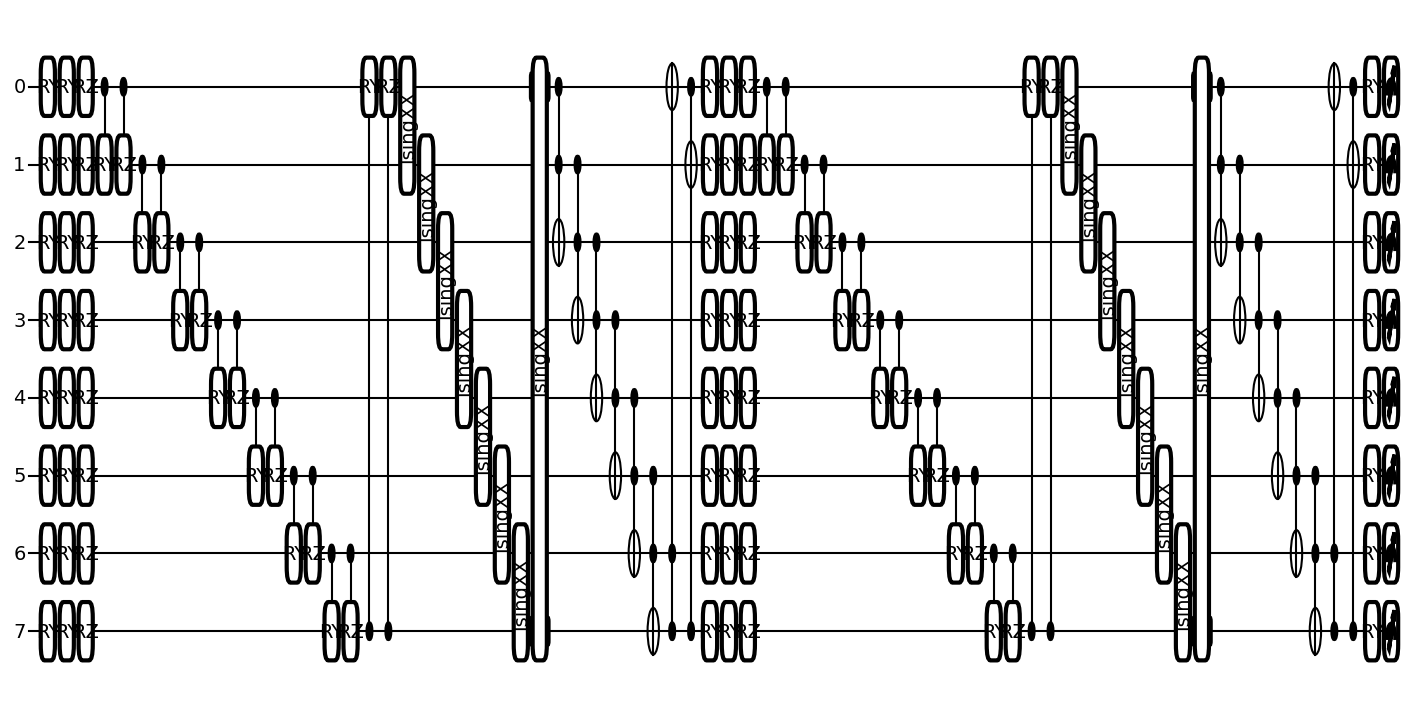

Saved figure → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/vqc8_models_spsa/circuit_vqc8.png


In [9]:

sample_angles = X_train[0] if "X_train" in globals() else np.zeros(N_QUBITS)
theta_vis = {
    "single": np.zeros((LAYERS, N_QUBITS, 2)),
    "ent":    np.zeros((LAYERS, N_QUBITS, 2)),
    "ising":  np.zeros((LAYERS, N_QUBITS)),
    "mix":    np.zeros((LAYERS, N_QUBITS, 1)),
}
print(qml.draw(vqc_multi)(sample_angles, theta_vis))
fig, ax = qml.draw_mpl(vqc_multi)(sample_angles, theta_vis)
fig.set_size_inches(14, 3 + 0.5 * N_QUBITS)
plt.tight_layout()
from pathlib import Path as _P
png_path = _P(OUT_DIR) / "circuit_vqc8.png"
fig.savefig(png_path, dpi=200)
plt.show()
print("Saved figure →", png_path.resolve())
